In [1]:
suppressPackageStartupMessages(library(Seurat))
library(dplyr)
library(pheatmap)
library(RColorBrewer)
library(ggplot2)
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")

library(repr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘scales’ was built under R version 4.4.3”
Warning message:
“package ‘Matrix’ was built under R version 4.4.3”
Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [13]:
rmeta <- read.csv("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_metadata.txt", sep = "\t", header = T)

## Plot histone modification TSSe

Using library as id variables

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


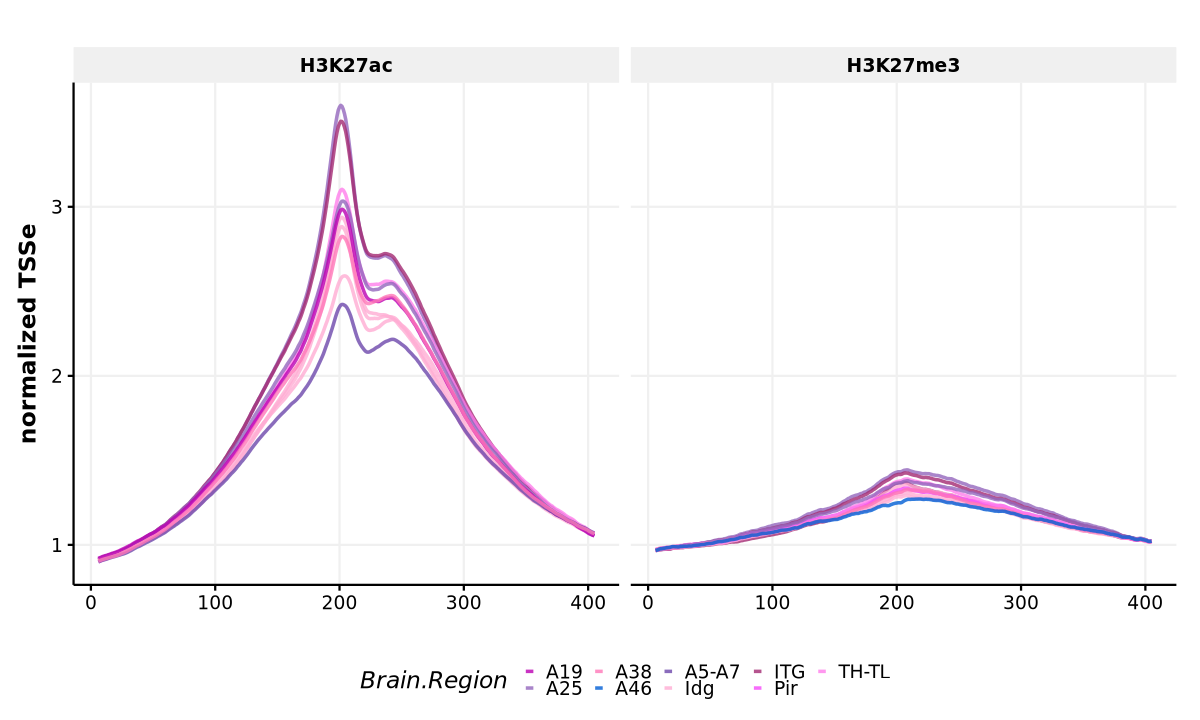

In [8]:
### unhashed
ssc <- read.table("bulk_QC/TSSe/MiniAtlas_single_channel_average_TSSe.xls")
meta <- read.csv('single_channel_metadata_240715.xls', header = T, sep = '\t') 
color <- read.csv("/projects/ps-renlab2/y2xie/projects/BICAN/ref/yel_Science2023_supp/brain_dissection_anno.xls", header = T, sep = "\t")

### set color code by region
cols <- color$Brain.region.color
names(cols) <- color$Brain.region

ssc_bg <- ssc[,c(1:5, 395:400)] %>% rowMeans
tmp <- (ssc / ssc_bg) %>% as.data.frame %>%
tibble::rownames_to_column('library') %>%
reshape2::melt() %>%
mutate(variable = as.integer(gsub("X", "", variable))) 

options(repr.plot.width = 10, repr.plot.height = 6)
t1 <- merge(tmp, meta[,c('DNA', 'Brain.Region', 'Histone.modifications')], by.x = 'library', by.y = 'DNA') %>%
ggplot(aes(x = variable, y = value, color = Brain.Region, group = library)) + 
geom_line(alpha = 0.8, linewidth = 1) + 
theme_Publication() + xlab("") + ylab("normalized TSSe") + 
scale_color_manual(values = cols) +
facet_grid(. ~ Histone.modifications)

t1

Using condition, library, target as id variables

`summarise()` has grouped output by 'target'. You can override using the `.groups` argument.
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


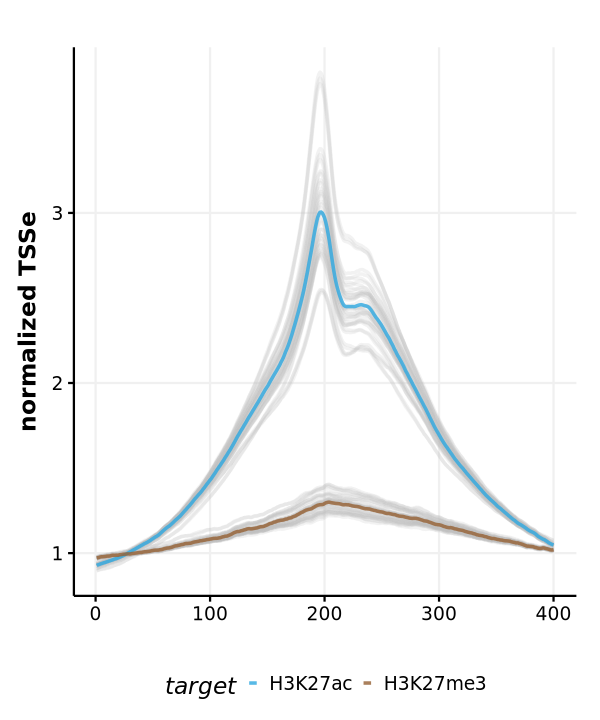

In [38]:
### hash
ssc <- read.table("bulk_QC/TSSe/MiniAtlas_multiplex_average_TSSe.xls") %>% t %>% as.data.frame
meta <- read.csv('multiplex_metadata_230128.xls', header = T, sep = '\t') %>%
mutate(condition = paste0(DNA, "_", Histone.modifications))
ssc_bg <- ssc[,c(1:5, 395:400)] %>% rowMeans
tmp <- (ssc[,1:400] / ssc_bg) %>% as.data.frame %>% tibble::rownames_to_column("condition")
tmp[,c('library', 'target')] <- stringr::str_split_fixed(rownames(ssc), n = 2, pattern = "_")
tmp <- tmp %>% reshape2::melt()

options(repr.plot.width = 5, repr.plot.height = 6)
ttp <- merge(tmp, distinct(meta[,c('condition', 'Brain.Region')]), by = 'condition')
ttp_sum <- ttp %>% group_by(target, variable) %>% summarise(mean_value = mean(value))
t1 <- ttp %>%
ggplot(aes(x = as.integer(variable), y = value, group = condition)) + 
geom_line(linewidth = 1, color = "grey", alpha = 0.2) + 
geom_line(data = ttp_sum, aes(x = as.integer(variable), y = mean_value, group = target, color = target), linewidth = 1, alpha = 0.8) +
theme_Publication() + xlab("") + ylab("normalized TSSe") + 
scale_colour_manual(values = c("#2EA7E0", "#956134"))

t1

`summarise()` has grouped output by 'condition', 'target'. You can override using the `.groups` argument.
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


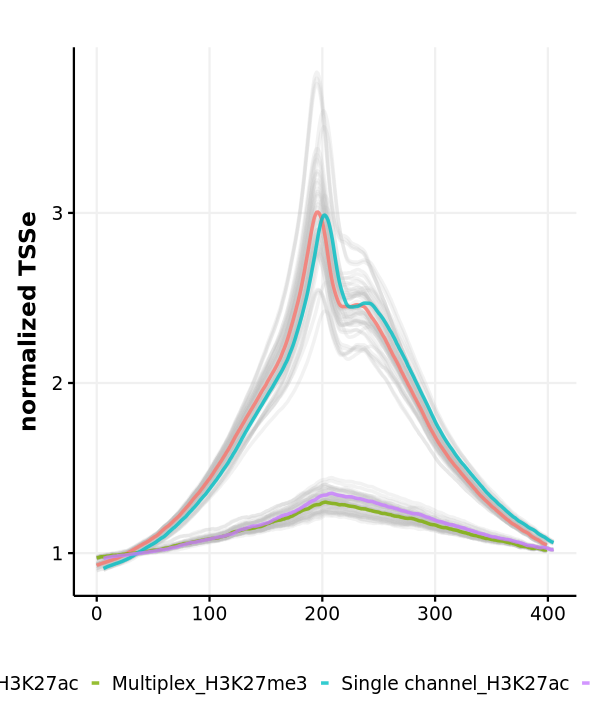

In [44]:
### Merge single channel and multiplex for comparasion
data1 <- read.table("../Figure/EXTD1_single_channel_TSSe_by_region_240131.xls") %>% 
mutate(condition = "Single channel", target = Histone.modifications)
data2 <- read.table("../Figure/EXTD1_multiplex_TSSe_by_region_240131.xls") %>% mutate(condition = "Multiplex")

ttp <- rbind(data1[,c("library", "variable", "value", "Brain.Region", "target", "condition")], data2[,c("library", "variable", "value", "Brain.Region", "target", "condition")]) %>%
mutate(group = paste0(library, "_", target))

ttp_sum <- ttp %>% 
group_by(condition, target, variable) %>% 
summarise(mean_value = mean(value)) %>%
mutate(group = paste0(condition, "_", target))

options(repr.plot.width = 5, repr.plot.height = 6)

t1 <- ttp %>%
ggplot(aes(x = as.integer(variable), y = value, group = group)) + 
geom_line(linewidth = 1, color = "grey", alpha = 0.2) + 
geom_line(data = ttp_sum, aes(x = as.integer(variable), y = mean_value, group = group, color = group), linewidth = 1, alpha = 0.8) +
theme_Publication() + xlab("") + ylab("normalized TSSe")

t1

## For different stragety, plot libraries complexity, cells number recovered

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'rna'. You can override using the `.groups` argument.


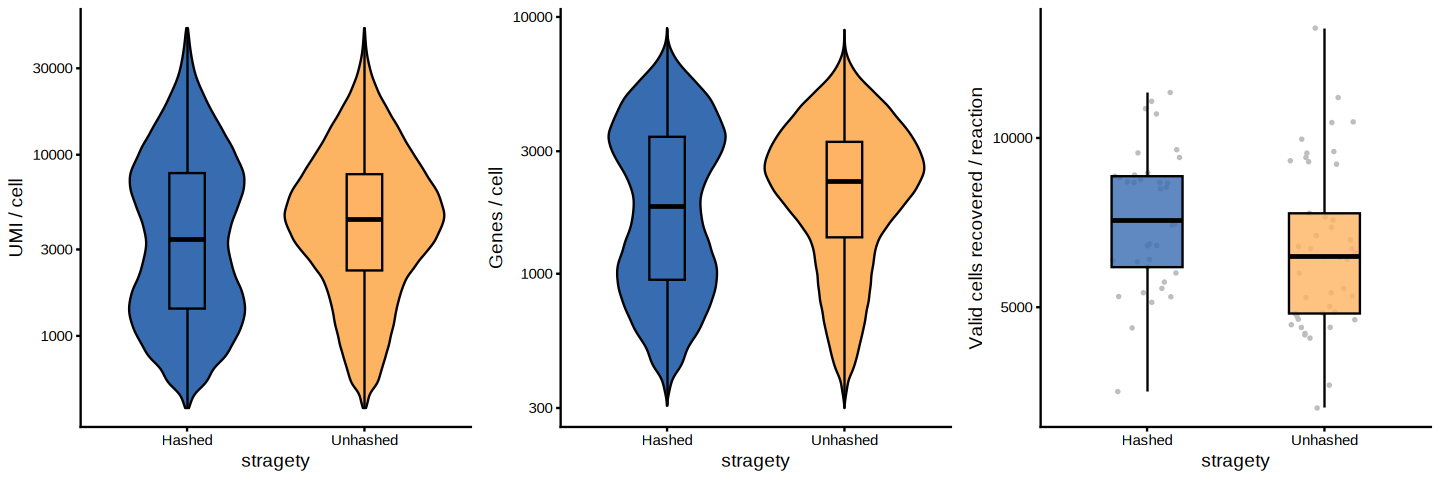

In [14]:
### check RNA compleity first
### since we include Pons and CB data generated using new strageties, it is unfair to include them for comparsion
t1 <- rmeta %>% filter(structure == "Cortex") %>%
mutate(stragety = ifelse(!is.na(index), "Hashed", "Unhashed")) %>%
ggplot(aes(x = stragety, fill = stragety, y = nCount_RNA)) + 
geom_violin(color = "black") + 
geom_boxplot(width=0.2, color="black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_classic() + scale_fill_Publication() + 
scale_y_log10() + ylab("UMI / cell") + theme(legend.position = "none")

t2 <- rmeta %>% filter(structure == "Cortex") %>%
mutate(stragety = ifelse(!is.na(index), "Hashed", "Unhashed")) %>%
ggplot(aes(x = stragety, fill = stragety, y = nFeature_RNA)) + 
geom_violin(color = "black") + 
geom_boxplot(width=0.2, color="black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_classic() + scale_fill_Publication() + 
scale_y_log10() + ylab("Genes / cell") + theme(legend.position = "none")

t3 <- rmeta %>% filter(structure == "Cortex") %>%
mutate(stragety = ifelse(!is.na(index), "Hashed", "Unhashed")) %>%
group_by(rna) %>%
summarise(celln = n(), stragety = stragety) %>%
ungroup() %>% distinct %>%
ggplot(aes(x = stragety, fill = stragety, y = celln)) + 
geom_jitter(color = "grey", size = 0.5, width = 0.2) + 
geom_boxplot(width=0.4, color="black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_classic() + scale_fill_Publication() + 
ylab("Valid cells recovered / reaction") + theme(legend.position = "none")

options(repr.plot.width = 12, repr.plot.height = 4)
t4 <- cowplot::plot_grid(t1, t2, t3, nrow = 1)

t4

In [15]:
rmeta %>% filter(structure == "Cortex") %>%
mutate(stragety = ifelse(!is.na(index), "Hashed", "Unhashed")) %>%
group_by(stragety) %>% summarise(nCount_RNA = median(nCount_RNA), nFeature_RNA = median(nFeature_RNA))

stragety,nCount_RNA,nFeature_RNA
<chr>,<dbl>,<dbl>
Hashed,3403,1834
Unhashed,4381,2279


In [28]:
dmeta1 <- read.csv("../04.clustering/01.DNA/MiniAtlas_H3K27ac_merged_dual_filt_clean_keep_250918_UMAP_cood_new.txt", header = T, row.names = 1)
dmeta2 <- read.csv("../04.clustering/01.DNA/MiniAtlas_H3K27me3_merged_dual_filt_clean_keep_250918_UMAP_cood_new.txt", header = T, row.names = 1)
scol <- intersect(colnames(dmeta1), colnames(dmeta2))
dmeta <- rbind(dmeta1[,scol], dmeta2[,scol])

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'dna'. You can override using the `.groups` argument.


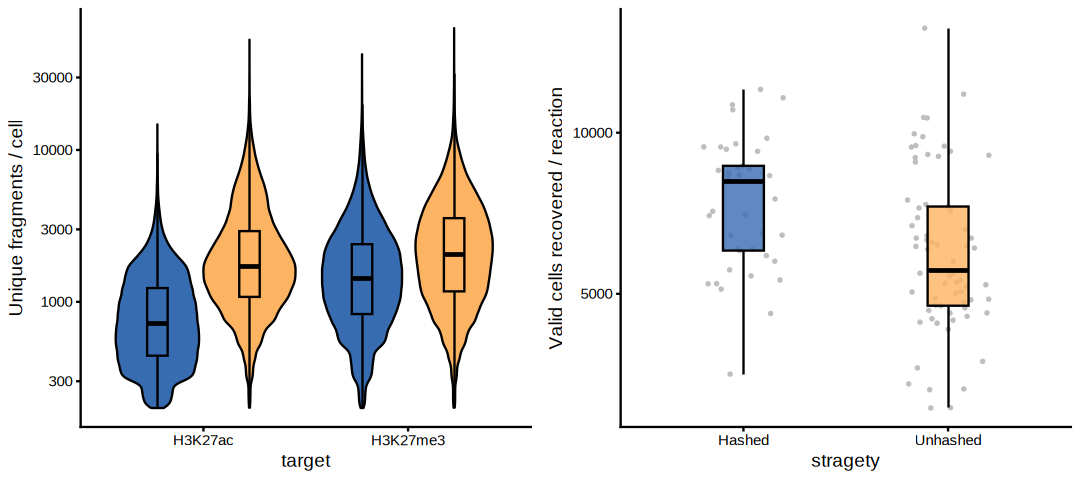

In [29]:
t1 <- dmeta %>% 
mutate(stragety = ifelse(!is.na(index), "Hashed", "Unhashed")) %>%
ggplot(aes(x = target, fill = stragety, y = n_fragment)) + 
geom_violin(color = "black", position = position_dodge(width = 0.9)) + 
geom_boxplot(width=0.2, color="black", alpha=0.8, coef = 2, outlier.shape = NA, position = position_dodge(width = 0.9)) + 
theme_classic() + scale_fill_Publication() + 
scale_y_log10() + ylab("Unique fragments / cell") + theme(legend.position = "none")

t2 <- dmeta %>% 
mutate(stragety = ifelse(!is.na(index), "Hashed", "Unhashed")) %>%
group_by(dna) %>%
summarise(celln = n(), stragety = stragety) %>%
ungroup() %>% distinct %>%
ggplot(aes(x = stragety, fill = stragety, y = celln)) + 
geom_jitter(color = "grey", size = 0.5, width = 0.2) + 
geom_boxplot(width=0.2, color="black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_classic() + scale_fill_Publication() + 
ylab("Valid cells recovered / reaction") + theme(legend.position = "none")

options(repr.plot.width = 9, repr.plot.height = 4)
t4 <- cowplot::plot_grid(t1, t2, nrow = 1)

t4

## For different donors, plot library complexity on bulk level

In [30]:
dna_summ <- list()
for (f in list.files(path = "/projects/ps-renlab2/y2xie/projects/BICAN/analysis/81.cellranger/DNA/")){
    if (f != "nohup.out"){
        tmp <- read.csv(paste0("/projects/ps-renlab2/y2xie/projects/BICAN/analysis/81.cellranger/DNA/", f, "/outs/summary.csv")) %>% 
        mutate(sample = f) %>% t %>% as.data.frame
        
        dna_summ[[f]] <- tmp
    }
}
dna_summ <- do.call(cbind, dna_summ)
colnames(dna_summ) <- dna_summ["Sample.ID",]
dna_summ <- dna_summ[, unique(dmeta$dna)] %>% t %>% as.data.frame
head(dna_summ)

,Sample.ID,Genome,Pipeline.version,Estimated.number.of.cells,Confidently.mapped.read.pairs,Estimated.bulk.library.complexity,Fraction.of.genome.in.peaks,Fraction.of.high.quality.fragments.in.cells,Fraction.of.high.quality.fragments.overlapping.TSS,Fraction.of.high.quality.fragments.overlapping.peaks,⋯,Q30.bases.in.barcode,Q30.bases.in.read.1,Q30.bases.in.read.2,Q30.bases.in.sample.index.i1,Sequenced.read.pairs,Sequencing.saturation,TSS.enrichment.score,Unmapped.read.pairs,Valid.barcodes,sample
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BC813,BC813,GRCh38,cellranger-atac-2.0.0,10299,0.8875,90833430,0.0316,0.9088,0.1828,0.2862,⋯,0.9121,0.9227,0.9449,0.8917,327341249,0.8185,3.8592,0.0239,0.9679,BC813
BC842,BC842,GRCh38,cellranger-atac-2.0.0,11451,0.8552,136450502,0.039,0.5146,0.1672,0.2602,⋯,0.8881,0.8919,0.9083,0.8812,214845461,0.6097,2.8995,0.043,0.9512,BC842
BC857,BC857,GRCh38,cellranger-atac-2.0.0,10478,0.8829,126727832,0.0336,0.7409,0.1762,0.2653,⋯,0.9097,0.9253,0.9465,0.9178,313046073,0.7374,3.1299,0.0234,0.9676,BC857
BI007,BI007,GRCh38,cellranger-atac-2.0.0,10941,0.9569,27963216,0.007,0.9045,0.2223,0.1474,⋯,0.8932,0.9429,0.9188,NA,155607148,0.9268,2.7284,0.002,0.9624,BI007
BI009,BI009,GRCh38,cellranger-atac-2.0.0,209,0.9557,33011456,0.0124,0.5456,0.2569,0.2862,⋯,0.8722,0.9465,0.9137,NA,179325323,0.9311,3.6163,0.0022,0.9586,BI009
BI023,BI023,GRCh38,cellranger-atac-2.0.0,15352,0.9586,61258008,0.0193,0.9275,0.243,0.2823,⋯,0.8759,0.9496,0.9168,NA,361920175,0.9365,3.3254,0.0019,0.9584,BI023


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


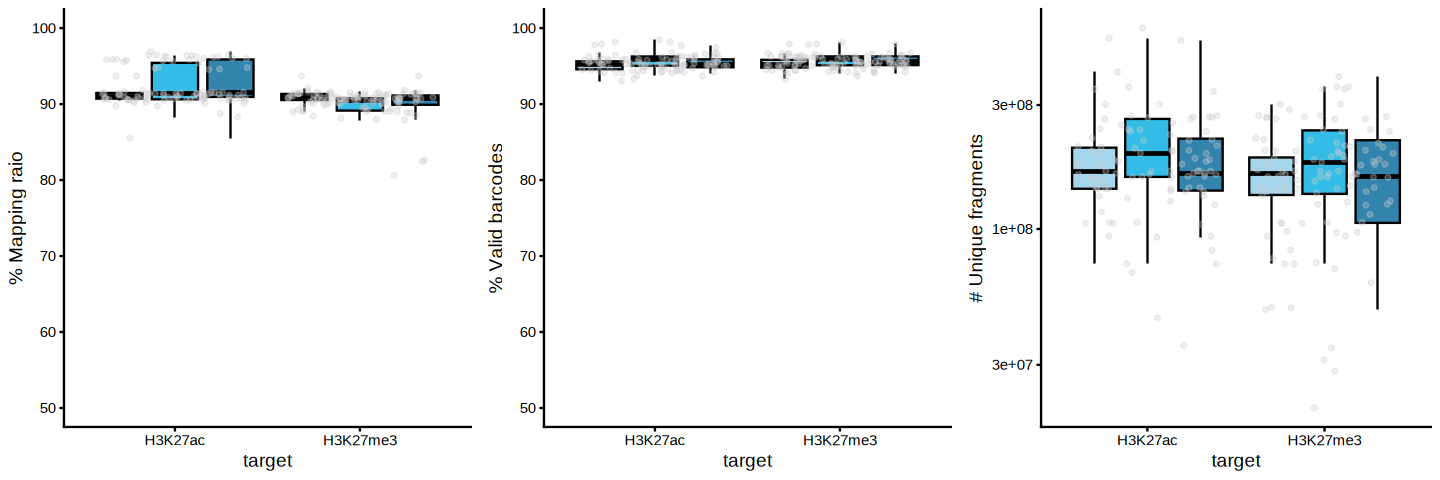

In [32]:
options(repr.plot.width = 12, repr.plot.height = 4)

t1 <- merge(dna_summ, dmeta, by.x = 0, by.y = "dna") %>% 
dplyr::select(donor, target, Confidently.mapped.read.pairs, Row.names) %>% distinct %>%
ggplot(aes(x = target, y = 100*as.numeric(Confidently.mapped.read.pairs), fill = donor)) + 
geom_boxplot(color="black", alpha=0.8, coef = 2, outlier.shape = NA, position = position_dodge(width = 0.9)) + 
geom_jitter(color = "#CAC9CD", alpha = 0.3, size = 1) +
theme_classic() + scale_fill_manual(values = c("#8ecae6", "#00acdf", "#006699")) + 
ylim(50, 100) + 
ylab("% Mapping raio") + theme(legend.position = "none")

t2 <- merge(dna_summ, dmeta, by.x = 0, by.y = "dna") %>% 
dplyr::select(donor, target, Valid.barcodes, Row.names) %>% distinct %>%
ggplot(aes(x = target, y = 100*as.numeric(Valid.barcodes), fill = donor)) + 
geom_boxplot(color="black", alpha=0.8, coef = 2, outlier.shape = NA, position = position_dodge(width = 0.9)) + 
geom_jitter(color = "#CAC9CD", alpha = 0.3, size = 1) + 
theme_classic() + scale_fill_manual(values = c("#8ecae6", "#00acdf", "#006699")) +
ylim(50, 100) + 
ylab("% Valid barcodes") + theme(legend.position = "none")

t3 <- merge(dna_summ, dmeta, by.x = 0, by.y = "dna") %>% 
dplyr::select(donor, target, Sequenced.read.pairs, Sequencing.saturation, Row.names) %>% distinct %>%
ggplot(aes(x = target, y = as.numeric(Sequenced.read.pairs)*as.numeric(Sequencing.saturation), fill = donor)) + 
geom_boxplot(color="black", alpha=0.8, coef = 2, outlier.shape = NA, position = position_dodge(width = 0.9)) + 
geom_jitter(color = "#CAC9CD", alpha = 0.3, size = 1) +
theme_classic() + scale_fill_manual(values = c("#8ecae6", "#00acdf", "#006699")) +
scale_y_log10() + 
ylab("# Unique fragments") + theme(legend.position = "none")

t4 <- cowplot::plot_grid(t1,  t2, t3, nrow = 1)

t4

In [36]:
rna_summ <- list()
for (f in unique(rmeta$rna)){
    tmp <- read.csv(paste0("/projects/ps-renlab2/y2xie/projects/BICAN/analysis/81.cellranger/RNA/", f, "/outs/metrics_summary.csv")) %>% 
    mutate(sample = f) %>% t %>% as.data.frame
    
    rna_summ[[f]] <- tmp
}
rna_summ <- do.call(cbind, rna_summ)
colnames(rna_summ) <- rna_summ["sample",]
rna_summ <- rna_summ[, unique(rmeta$rna)] %>% t %>% as.data.frame
head(rna_summ)

,Estimated.Number.of.Cells,Mean.Reads.per.Cell,Median.Genes.per.Cell,Number.of.Reads,Valid.Barcodes,Sequencing.Saturation,Q30.Bases.in.Barcode,Q30.Bases.in.RNA.Read,Q30.Bases.in.UMI,Reads.Mapped.to.Genome,Reads.Mapped.Confidently.to.Genome,Reads.Mapped.Confidently.to.Intergenic.Regions,Reads.Mapped.Confidently.to.Intronic.Regions,Reads.Mapped.Confidently.to.Exonic.Regions,Reads.Mapped.Confidently.to.Transcriptome,Reads.Mapped.Antisense.to.Gene,Fraction.Reads.in.Cells,Total.Genes.Detected,Median.UMI.Counts.per.Cell,sample
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
LC695,"4,106","25,238","2,692","103,627,328",96.5%,24.2%,95.0%,94.2%,95.3%,96.4%,91.7%,6.5%,72.4%,12.8%,74.4%,9.7%,61.2%,"31,870","6,780",LC695
LC694,"10,723","11,144","2,168","119,501,835",95.8%,27.7%,95.0%,94.3%,95.3%,96.9%,92.0%,5.5%,68.4%,18.2%,72.7%,12.9%,94.1%,"32,827","4,416",LC694
BI013,"2,465","150,183","3,632","370,199,868",93.7%,62.0%,97.3%,97.2%,98.1%,97.4%,93.1%,4.4%,70.1%,18.6%,70.1%,17.7%,90.7%,"32,560","10,472",BI013
BI014,"3,946","82,013","3,582","323,623,636",93.5%,50.5%,97.2%,97.3%,98.1%,97.5%,93.2%,4.3%,70.7%,18.2%,70.2%,17.7%,48.5%,"31,675","9,844",BI014
BI015,"6,124","50,105","2,452","306,844,783",93.6%,66.3%,96.9%,96.9%,97.9%,97.2%,92.1%,4.4%,69.1%,18.6%,70.0%,16.8%,71.5%,"31,380","5,794",BI015
BI016,"8,272","33,978","2,085","281,067,245",93.6%,62.9%,96.9%,97.1%,98.0%,97.3%,92.5%,4.4%,69.7%,18.4%,69.4%,17.8%,69.8%,"31,411","4,464",BI016


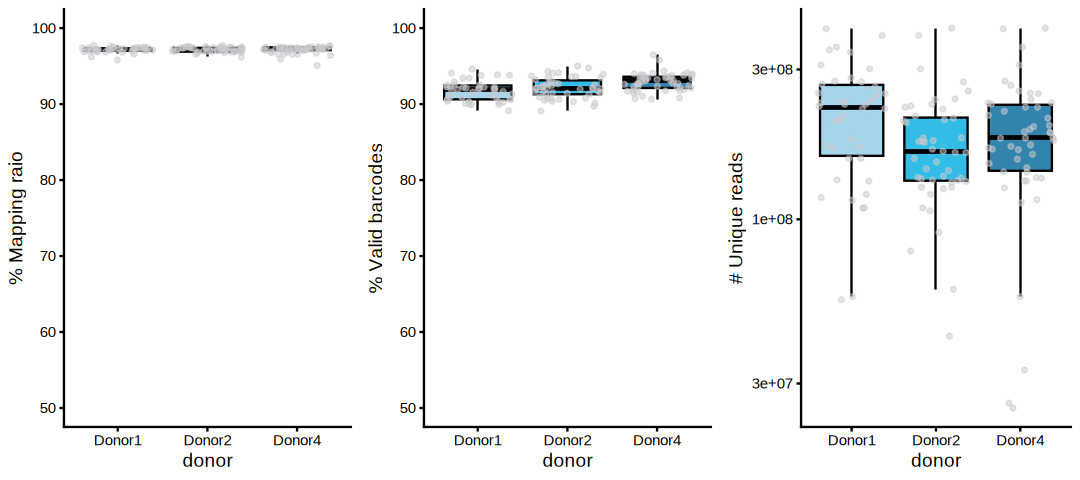

In [39]:
options(repr.plot.width = 9, repr.plot.height = 4)

t1 <- merge(rna_summ, rmeta, by.x = 0, by.y = "rna") %>% 
dplyr::select(donor, Reads.Mapped.to.Genome, Row.names) %>% distinct %>%
mutate(Reads.Mapped.to.Genome = gsub("%", "", Reads.Mapped.to.Genome)) %>%
ggplot(aes(x = donor, y = as.numeric(Reads.Mapped.to.Genome), fill = donor)) + 
geom_boxplot(color="black", alpha=0.8, coef = 2, outlier.shape = NA) + 
geom_jitter(color = "#CAC9CD", alpha = 0.5, size = 1) +
theme_classic() + scale_fill_manual(values = c("#8ecae6", "#00acdf", "#006699")) + 
ylim(50, 100) + 
ylab("% Mapping raio") + theme(legend.position = "none")

t2 <- merge(rna_summ, rmeta, by.x = 0, by.y = "rna") %>% 
dplyr::select(donor, Valid.Barcodes, Row.names) %>% distinct %>%
mutate(Valid.Barcodes = gsub("%", "", Valid.Barcodes)) %>%
ggplot(aes(x = donor, y = as.numeric(Valid.Barcodes), fill = donor)) + 
geom_boxplot(color="black", alpha=0.8, coef = 2, outlier.shape = NA) + 
geom_jitter(color = "#CAC9CD", alpha = 0.5, size = 1) + 
theme_classic() + scale_fill_manual(values = c("#8ecae6", "#00acdf", "#006699")) +
ylim(50, 100) + 
ylab("% Valid barcodes") + theme(legend.position = "none")

t3 <- merge(rna_summ, rmeta, by.x = 0, by.y = "rna") %>% 
dplyr::select(donor, Number.of.Reads, Sequencing.Saturation, Row.names) %>% distinct %>%
mutate(Number.of.Reads = gsub(",", "", Number.of.Reads), Sequencing.Saturation = gsub("%", "", Sequencing.Saturation)) %>%
ggplot(aes(x = donor, y = as.numeric(Number.of.Reads)*as.numeric(Sequencing.Saturation)/100, fill = donor)) + 
geom_boxplot(color="black", alpha=0.8, coef = 2, outlier.shape = NA) + 
geom_jitter(color = "#CAC9CD", alpha = 0.5, size = 1) +
theme_classic() + scale_fill_manual(values = c("#8ecae6", "#00acdf", "#006699")) +
scale_y_log10() + 
ylab("# Unique reads") + theme(legend.position = "none")

t4 <- cowplot::plot_grid(t1, t2, t3, nrow = 1)

t4

## For different donors, plot library complexity on single cell level

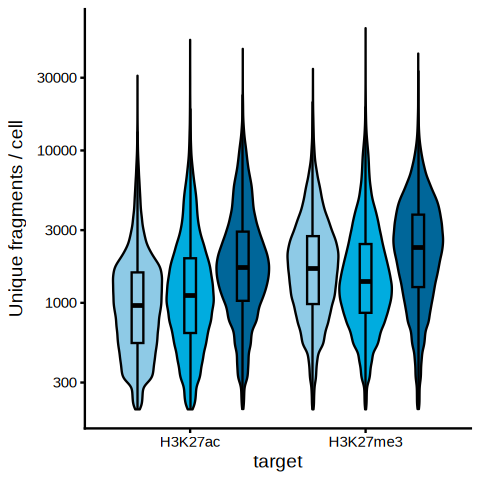

In [40]:
options(repr.plot.width = 4, repr.plot.height = 4)
t1 <- dmeta %>%
ggplot(aes(x = target, y = n_fragment, fill = donor)) + 
geom_violin(color = "black", position = position_dodge(width = 0.9)) + 
geom_boxplot(width=0.2, color="black", alpha=0.8, coef = 2, outlier.shape = NA, position = position_dodge(width = 0.9)) + 
theme_classic() + scale_fill_manual(values = c("#8ecae6", "#00acdf", "#006699")) +
scale_y_log10() + 
ylab("Unique fragments / cell") + theme(legend.position = "none")

t1

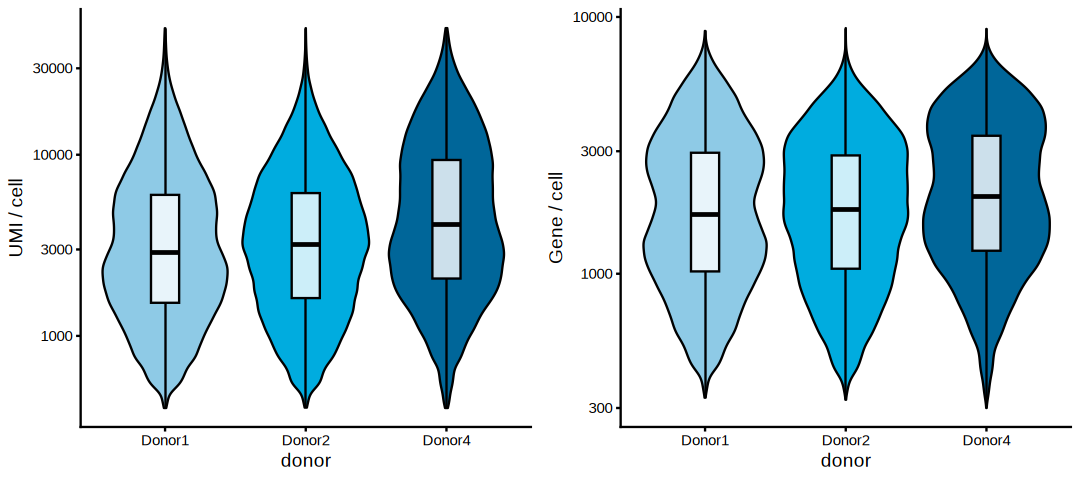

In [41]:
t1 <- rmeta %>%
ggplot(aes(x = donor, y = nCount_RNA, fill = donor)) + 
geom_violin(color = "black") + 
geom_boxplot(fill = "white", width=0.2, color="black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_classic() + scale_fill_manual(values = c("#8ecae6", "#00acdf", "#006699")) +
scale_y_log10() + 
ylab("UMI / cell") + theme(legend.position = "none")

t2 <- rmeta %>%
ggplot(aes(x = donor, y = nFeature_RNA, fill = donor)) + 
geom_violin(color = "black") + 
geom_boxplot(fill = "white", width=0.2, color="black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_classic() + scale_fill_manual(values = c("#8ecae6", "#00acdf", "#006699")) +
scale_y_log10() + 
ylab("Gene / cell") + theme(legend.position = "none")

options(repr.plot.width = 9, repr.plot.height = 4)
t4 <- cowplot::plot_grid(t1, t2, nrow = 1)

t4

## For different regions / donors, plot SCC between sample on pseudobulk level

In [64]:
### RNA SCC: using variable genes
mmg <- qs::qread("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250529.qs")
mmg$stragety <- "Hashed"
mmg@meta.data[is.na(mmg$index),]$stragety <- "Unhashed"
mmg$condition <- paste0(mmg$donor, "_", mmg$stragety, "_", mmg$region)

var_features <- VariableFeatures(mmg)
expr <- AverageExpression(mmg, features = rownames(mmg), group.by = "condition")
ttp1 <- log2(as.matrix(expr$RNA[var_features,])+1) %>% cor

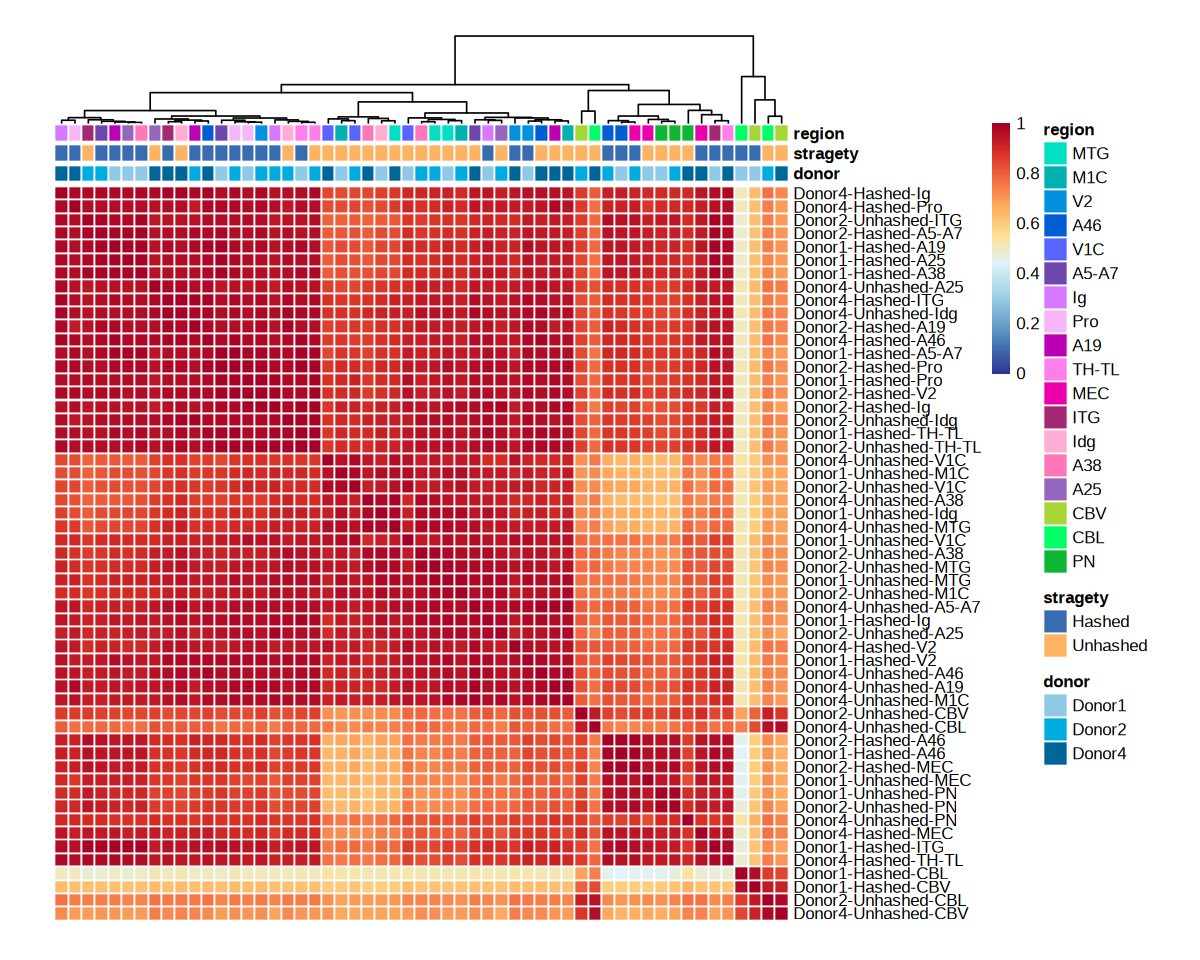

In [68]:
rdata <- colnames(ttp1) %>% as.data.frame %>% setNames("name")

### add annotation
rdata[,c("donor", "stragety", "region")] <- stringr::str_split_fixed(rdata$name, n = 3, pattern = "-")
rdata <- rdata %>% tibble::column_to_rownames("name") # %>% arrange(c(structure, region))

### add colors
color <- read.csv("/projects/ps-renlab2/y2xie/projects/BICAN/ref/yel_Science2023_supp/brain_dissection_anno.xls", header = T, sep = "\t")
color1 <- c("#386cb0", "#fdb462")
names(color1) <- c("Hashed", "Unhashed")
tcolor <- distinct(color[,c("Brain.region", "Brain.region.color")]) %>% filter(Brain.region %in% rdata$region)
color2 <- tcolor$Brain.region.color
names(color2) <- tcolor$Brain.region
color3 <- c("#8ecae6", "#00acdf", "#006699")
names(color3) <- c("Donor1", "Donor2", "Donor4")
acolor <- list(region = color2, stragety = color1, donor = color3)

options(repr.plot.width = 10, repr.plot.height = 8)
t1 <- ttp1 %>%
pheatmap(scale = "none", cluster_rows = T, cluster_cols = T, treeheight_row = 0, cellheight = 8, cellwidth = 8,
         show_colnames = F, annotation_col = rdata, annotation_colors = acolor,
         border_color = "white", display_numbers = F, number_color = "white", angle_col = 45,
         breaks = seq(0, 1, 0.01), color = rev(colorRampPalette(brewer.pal(n = 10, name = "RdYlBu"))(100)))

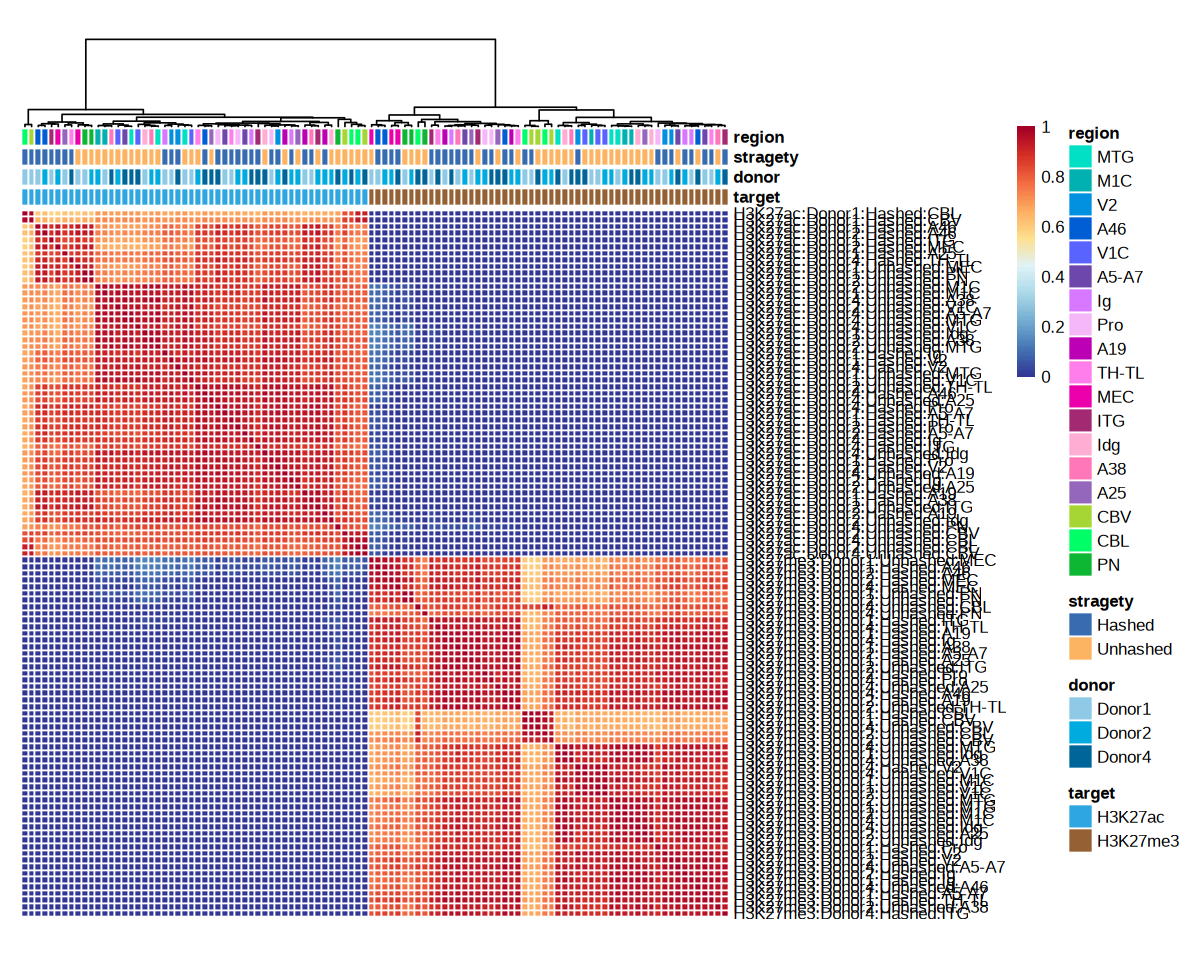

In [83]:
### DNA SCC: use snapatac2 to aggregate by condition
d1 <- read.csv('../04.clustering/01.DNA/MiniAtlas_H3K27ac_merged_dual_filt_clean_250722_donor-stragety-region.15kb.cpm.csv', check.names = F, row.names = 1)
d2 <- read.csv('../04.clustering/01.DNA/MiniAtlas_H3K27me3_merged_dual_filt_clean_250722_donor-stragety-region.15kb.cpm.csv', check.names = F, row.names = 1)

dna <- cbind(d1, d2)
ttp <- log2(dna+1) %>% cor(method = "pearson")
rdata <- colnames(ttp) %>% as.data.frame %>% setNames("name")

### add annotation
rdata[,c("target", "donor", "stragety", "region")] <- stringr::str_split_fixed(rdata$name, n = 4, pattern = ":")
rdata <- rdata %>% tibble::column_to_rownames("name") # %>% arrange(c(structure, region))

### add colors
color4 <- c("#2EA7E0", "#956134")
names(color4) <- c("H3K27ac", "H3K27me3")
acolor2 <- acolor #list(region = color2, structure = color1, donor = color3, target = color4)
acolor2[["target"]] <- color4

options(repr.plot.width = 10, repr.plot.height = 8)
t1 <- ttp %>%
pheatmap(scale = "none", cluster_rows = T, cluster_cols = T, treeheight_row = 0, cellheight = 4, cellwidth = 4,
         show_colnames = F, annotation_col = rdata, annotation_colors = acolor2,
         border_color = "white", display_numbers = F, number_color = "white", angle_col = 45,
         breaks = seq(0, 1, 0.01), color = rev(colorRampPalette(brewer.pal(n = 10, name = "RdYlBu"))(100)))